In [21]:
import torch
from transformers import AutoModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gc

# Вначале для удобства лучше все тестировать на 70M модели,
# но для итоговой презентации наверное нужно будет все прогнать на 2.7 B модели
model_name = "EleutherAI/pythia-410M"

checkpoint_steps = [0] + [2**i for i in range(1, 10)] + list(range(1000, 143001, 1000))
branch_names = [f"step{step}" for step in checkpoint_steps]

# Посмотрим как выглядит архитектура модели и как её доставать
model = AutoModel.from_pretrained(model_name, revision=branch_names[-1], trust_remote_code=True)
model

GPTNeoXModel(
  (embed_in): Embedding(50304, 1024)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-23): 24 x GPTNeoXLayer(
      (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (post_attention_dropout): Dropout(p=0.0, inplace=False)
      (post_mlp_dropout): Dropout(p=0.0, inplace=False)
      (attention): GPTNeoXSdpaAttention(
        (rotary_emb): GPTNeoXRotaryEmbedding()
        (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (attention_dropout): Dropout(p=0.0, inplace=False)
      )
      (mlp): GPTNeoXMLP(
        (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
        (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELUActivation()
      )
    )
  )
  (final_layer_n

In [28]:
up_bias_norms = {layer_idx: [] for layer_idx in range(24)}
down_bias_norms = {layer_idx: [] for layer_idx in range(24)}

# Итерация по всем контрольным точкам
for branch in tqdm(branch_names[::7], desc="Processing checkpoints"):
    try:
        # Загрузка модели для текущей контрольной точки
        model = AutoModel.from_pretrained(model_name, revision=branch, trust_remote_code=True)

        # Проходимся по всем слоям
        for layer_idx, layer in enumerate(model.layers):
            mlp = layer.mlp
            up_bias = mlp.dense_h_to_4h.bias.detach().numpy()
            down_bias = mlp.dense_4h_to_h.bias.detach().numpy()
            up_norm = np.linalg.norm(up_bias)
            down_norm = np.linalg.norm(down_bias)
            up_bias_norms[layer_idx].append(up_norm)
            down_bias_norms[layer_idx].append(down_norm)

    except Exception as e:
        print(f"Error processing {branch}: {e}")
    finally:
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

Processing checkpoints: 100%|██████████| 22/22 [01:53<00:00,  5.14s/it]


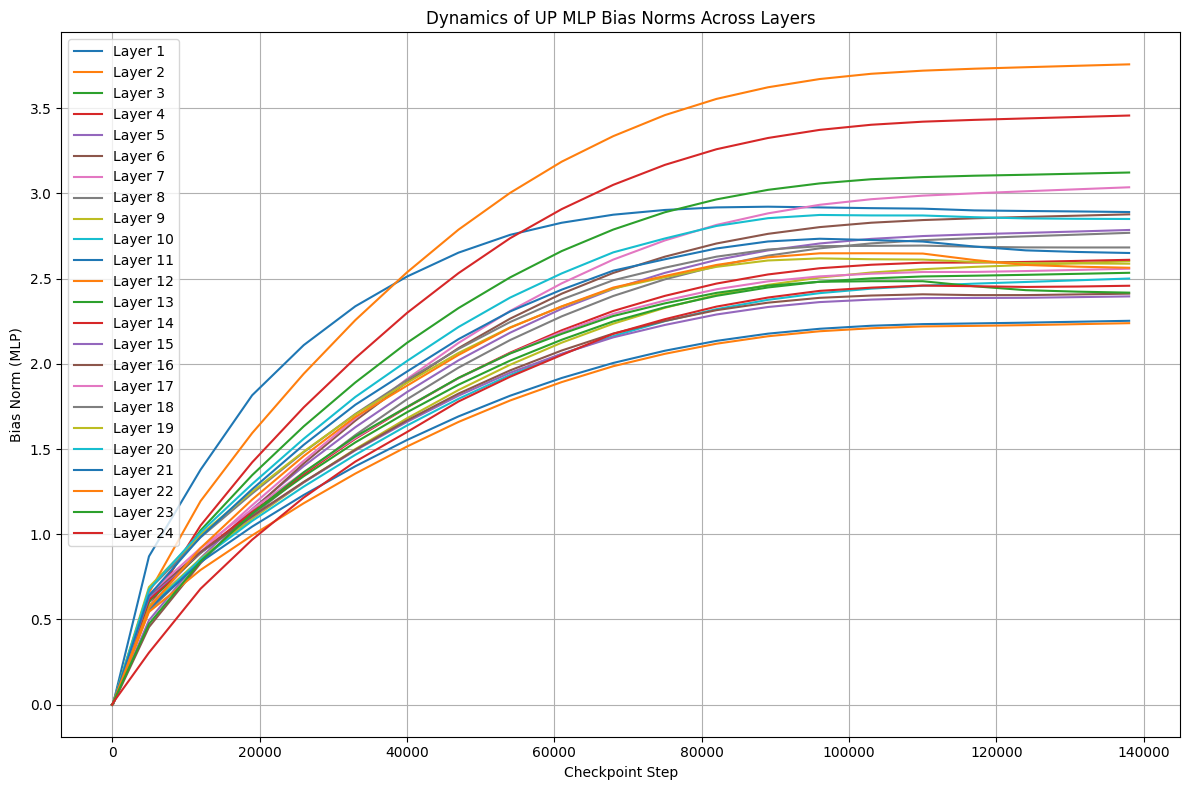

In [30]:
# Построение графика
plt.figure(figsize=(12, 8))
steps = checkpoint_steps[::7]

for layer_idx in range(24):
    plt.plot(steps, up_bias_norms[layer_idx], label=f'Layer {layer_idx + 1}')

plt.xlabel('Checkpoint Step')
plt.ylabel('Bias Norm (MLP)')
plt.title('Dynamics of UP MLP Bias Norms Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

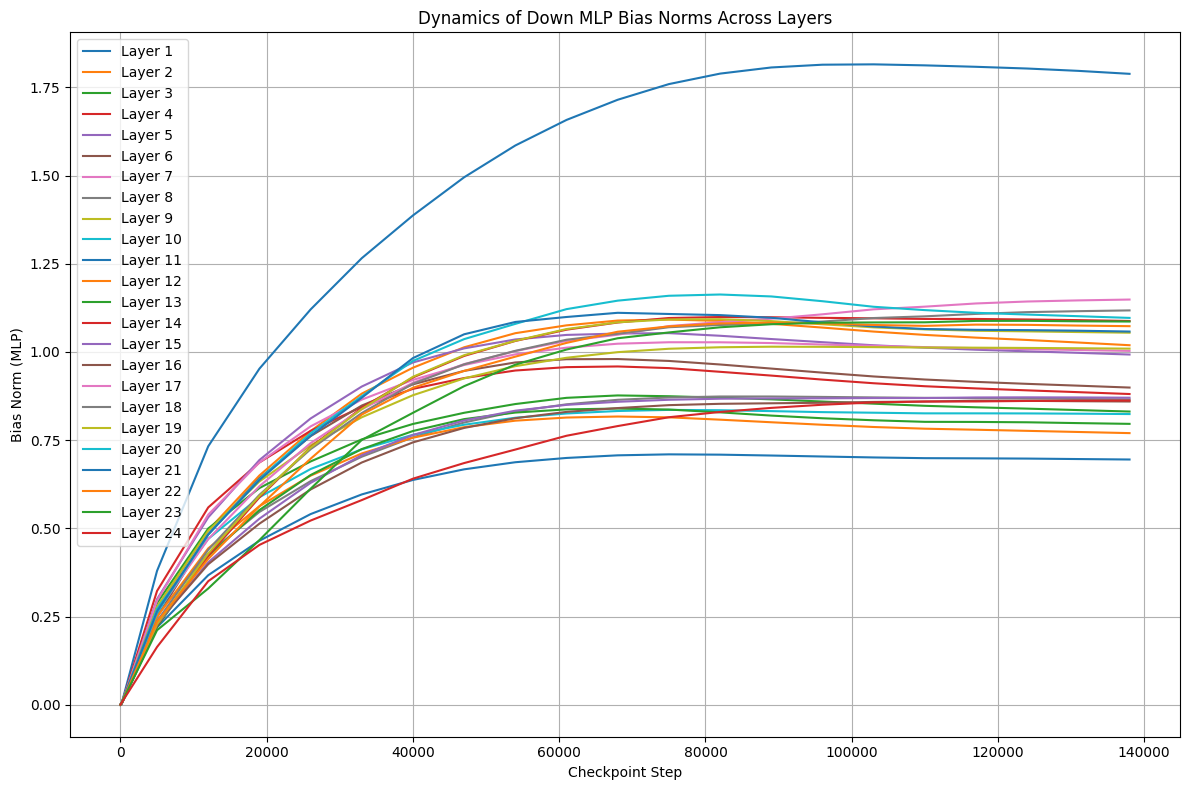

In [31]:
# Построение графика
plt.figure(figsize=(12, 8))
steps = checkpoint_steps[::7]

for layer_idx in range(24):
    plt.plot(steps, down_bias_norms[layer_idx], label=f'Layer {layer_idx + 1}')

plt.xlabel('Checkpoint Step')
plt.ylabel('Bias Norm (MLP)')
plt.title('Dynamics of Down MLP Bias Norms Across Layers')
plt.legend()
# plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
for i in range(24):
  print(down_bias_norms[i][-1])

1.7884935
1.0191306
0.8310971
0.8807802
0.9927285
0.89908826
1.0030125
0.8656911
1.00945
0.823951
0.6951259
0.7699349
0.7961826
1.0878992
0.87036175
0.85953736
1.1486031
1.1178265
1.0545915
1.0965481
1.0578804
1.0731093
1.0862745
0.8622946
